In [2]:
cd ..

/cluster/bh0085/prj/starr_all/starr/src


In [3]:
import os, re, sys, json
import numpy as np, pandas as pd
import _config
reload (_config)
from _config import SHE3202_FQ_FILES, EXP_DESIGN_2901, OLIGO_LIBRARY, SHE3202_DIR, A_BC_OLIGOS_OUT, POSITIVE_CONTROLS_FILE


In [15]:
oligo_info = pd.read_csv("../data/0612_oligo_exp_statistics.csv")

In [16]:

oligos_lib = OLIGO_LIBRARY
oligos_lib["id"] = oligos_lib.index
oligo_info2 = oligo_info.copy().join(oligos_lib, on ="oligo")#.dropna()


In [17]:

oligos_lib = OLIGO_LIBRARY
oligos_lib["id"] = oligos_lib.index
oligo_info2 = oligo_info.copy().join(oligos_lib, on ="oligo")#.dropna()

#test = oligo_info2
candid_regex = re.compile("candid_(\d+)")
neg_regex = re.compile("Neg_(\d+)")

mutant_regex = re.compile("mut(\d+)$")

oligos_lib["locus_ids"] = oligos_lib.RefSeqID.apply(lambda x: int(candid_regex.search(x).groups()[0]) if candid_regex.search(x) else neg_regex.search(x).groups()[0] )
oligos_lib["mutant_num"] = oligos_lib.RefSeqID.apply(lambda x: int(mutant_regex.search(x).groups()[0]) if mutant_regex.search(x) else 0 )
oligos_lib["is_cand"] = oligos_lib.RefSeqID.apply(lambda x: True if candid_regex.search(x) else False )
oligos_lib["is_neg"] = oligos_lib.RefSeqID.apply(lambda x: True if neg_regex.search(x) else False )


In [18]:

oligos_lib = OLIGO_LIBRARY
oligos_lib["id"] = oligos_lib.index
oligo_info2 = oligo_info.copy().join(oligos_lib, on ="oligo")#.dropna()

#test = oligo_info2
candid_regex = re.compile("candid_(\d+)")
neg_regex = re.compile("Neg_(\d+)")
mutant_regex = re.compile("mut(\d+)$")


oligos_lib["locus_ids"] = oligos_lib.RefSeqID.apply(lambda x: int(candid_regex.search(x).groups()[0]) if candid_regex.search(x) else neg_regex.search(x).groups()[0] )
oligos_lib["mutant_num"] = oligos_lib.RefSeqID.apply(lambda x: int(mutant_regex.search(x).groups()[0]) if mutant_regex.search(x) else 0 )
oligos_lib["is_cand"] = oligos_lib.RefSeqID.apply(lambda x: True if candid_regex.search(x) else False )
oligos_lib["is_neg"] = oligos_lib.RefSeqID.apply(lambda x: True if neg_regex.search(x) else False )


oligo_info2 = oligo_info2.join(oligos_lib[["locus_ids","mutant_num","is_cand","is_neg"]],on="oligo",rsuffix="right")
#oligo_info2["locus_ids"] = oligo_info2.join(oligos_lib[["locus_ids","mutant_num","is_cand","is_neg"]],on="oligo")
oligo_info2["mutant_num"] = oligo_info2.RefSeqID.apply(lambda x: int(mutant_regex.search(x).groups()[0]) if mutant_regex.search(x) else 0 )
oligo_info2["is_cand"] = oligo_info2.RefSeqID.apply(lambda x: True if candid_regex.search(x) else False )
oligo_info2["is_neg"] = oligo_info2.RefSeqID.apply(lambda x: True if neg_regex.search(x) else False )


In [19]:

oi2 = oligo_info2
oligos_lib["starts"] = oligos_lib.chromosome_info.apply(lambda x: int(re.compile("(\d+)-(\d+)").search(x).groups()[0]))
oligos_lib["starts"] = oligos_lib.starts-oligos_lib.starts.min()


In [21]:
enrichments = pd.DataFrame()
#enrichments_vs_all = pd.DataFrame()
#observations_vs_all = pd.DataFrame()
#enrichments.index =pd.Series( oligo_info2.oligo.unique())
for k,g in oligo_info2.groupby("exp"):
    #print  g.apply(lambda x:x.n_transcripts / x.n_observed_bcs)
    g = g.dropna()
    if len(g) == 0: continue
    enrichments[k] = pd.Series(g.apply(lambda x:x.n_transcripts / x.n_observed_bcs, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    #enrichments_vs_all[k] = pd.Series(g.apply(lambda x:x.n_transcripts / x.n_total_bcs, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    #observations_vs_all[k] = pd.Series(g.apply(lambda x:x.n_observed_bcs / x.n_total_bcs, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    #enrichments[k+"_vs_bcs"] = g.apply(lambda x:x.n_transcripts / x.n_observed_bcs, axis = 1)


In [22]:
enrichments["starts"] = oligos_lib.starts


# PLOTS #

In [23]:
from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
wid_multiplier = 20

AxisError: axis 1 is out of bounds for array of dimension 1

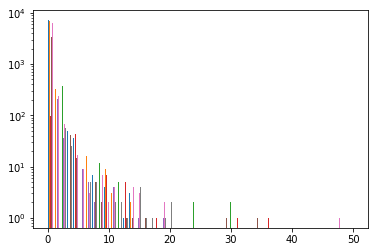

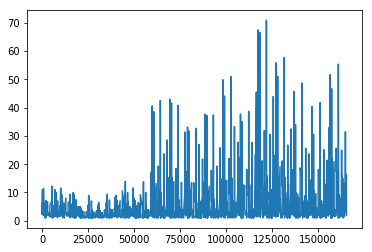

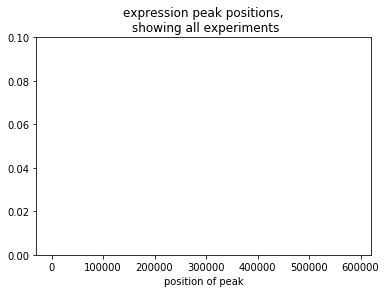

<Figure size 432x288 with 0 Axes>

In [29]:
from scipy.stats import zscore
ematrix = enrichments
arr = ematrix.iloc[:,:8].fillna(ematrix.iloc[:,:8].mean())

zs = zscore(arr,axis = 0)


#plt.plot(zs)

plt.hist(zs,bins=np.linspace(0,50))
plt.gca().set_yscale("log")

highz = np.nonzero(np.max(zs,axis=1)>4)[0]
#zs[highz,:]
#print highz
#print len(arr)
#print arr.values[highz,:]

hz_enriched = ematrix.iloc[highz,:]
hze_idxs = hz_enriched.index.values
hz_infos = oligo_info2.loc[oligo_info2.id.isin(hze_idxs)]

plt.figure()
allstarts = np.sort(hz_infos.starts.unique())

wid = 2

peak_ids = np.nonzero((allstarts[wid:] - allstarts[:-wid]) < 30*(wid+wid_multiplier))[0]
startvals = allstarts[peak_ids]

simple_peaks = oligo_info2.loc[oligo_info2.starts.isin(startvals)]
plt.plot(simple_peaks.n_transcripts / simple_peaks.n_observed_bcs)

plt.figure()
h = plt.hist(simple_peaks.mutant_num)

#plot transcript counts for all oligos located at the peaks
plt.plot(simple_peaks.starts,(simple_peaks.n_transcripts / simple_peaks.n_observed_bcs).fillna(0), "x")
plt.gca().set_ylim(0,.1)
plt.gca().set_title("expression peak positions,\n showing all experiments")
plt.gca().set_xlabel("position of peak")

plt.figure()
   
grps = simple_peaks.sort_values("exp").groupby("exp")
plt.hist([rows.starts for k,rows in grps],
 weights = [e for e in np.array([(rows.n_transcripts / rows.n_observed_bcs).fillna(0)  for k,rows in grps if len(rows)> 0]) /\
     np.sum(np.array([(rows.n_transcripts / rows.n_observed_bcs).fillna(0)  for k,rows in grps if len(rows) > 0] ),axis=1)[:,np.newaxis]],
density = False, bins = np.linspace(0,600000,15), label = [k for k,rows in grps if len(rows )> 0])
plt.legend()
plt.gcf().set_size_inches(12,6)

plt.figure()
f= plt.gcf()
efilled = ematrix.fillna(ematrix.mean())
f.set_size_inches(16,8)
plt.imshow(zscore(efilled.loc[simple_peaks.oligo.unique()[:64],:],axis=1).transpose())




In [30]:
simple_peaks.to_csv("../data/peaks_zscore4.csv")

In [ ]:
plt.hist([e for e in enrichments_vs_all.values.flatten() if e !=0],density=True, bins = np.linspace(0,.2,100),histtype="step", label="all regions")
plt.hist([e for e in enrichments_vs_all.loc[simple_peaks.oligo.unique()].values.flatten() if e!=0],density=True,bins = np.linspace(0,.2,100),histtype="step", label="peaks")
plt.gca().set_title("Histogram of enrichment values for peak regions")
plt.gca().set_xlabel("enrichment value (fraction of oligo barcodes in transcript dataset)")
plt.gca().set_yscale("log")
plt.legend()



In [32]:
plt.hist([list(e) for e in xvals], weights =[list(e) for e in weighted_yvals], 
                 bins = range(0, max(max(xs) for xs in xvals)+2),histtype="barstacked", color=colors,
                
                )

NameError: name 'xvals' is not defined

In [ ]:
plt.hist([list(e) for e in xvals], weights =[list(e) for e in weighted_yvals], 
                 bins = range(0, max(max(xs) for xs in xvals)+2),histtype="barstacked", color=colors,
                
                )

58


/cluster/bh0085/anaconda27/lib/python2.7/site-packages/pandas/core/frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)
/cluster/bh0085/anaconda27/lib/python2.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


IndexError: index 2 is out of bounds for axis 0 with size 2

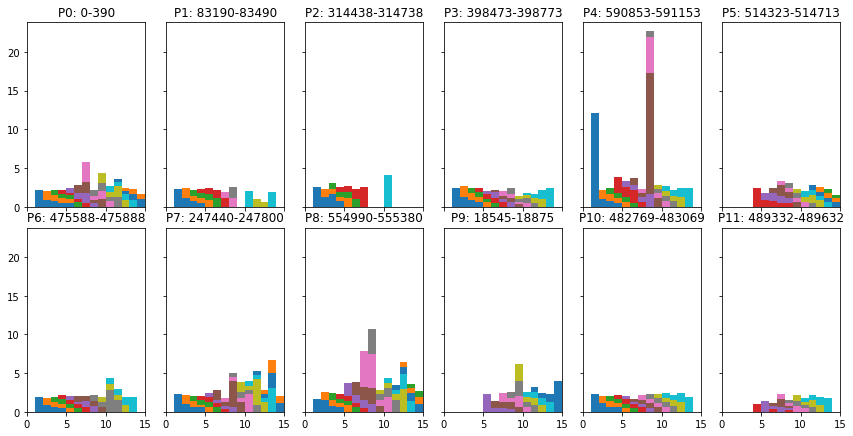

<Figure size 432x288 with 0 Axes>

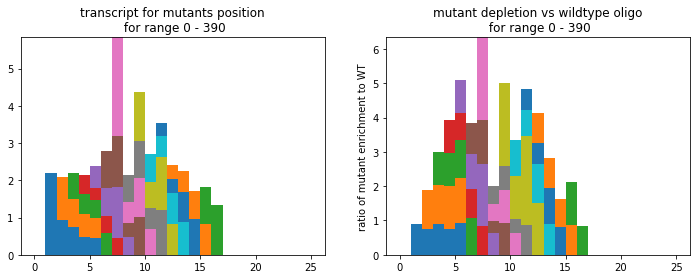

<Figure size 432x288 with 0 Axes>

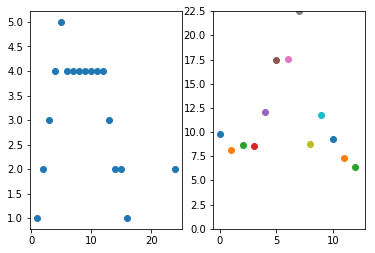

<Figure size 432x288 with 0 Axes>

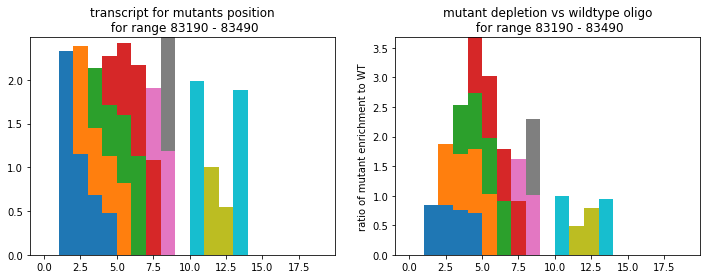

<Figure size 432x288 with 0 Axes>

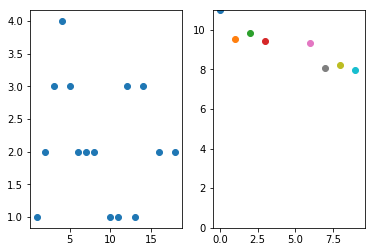

<Figure size 432x288 with 0 Axes>

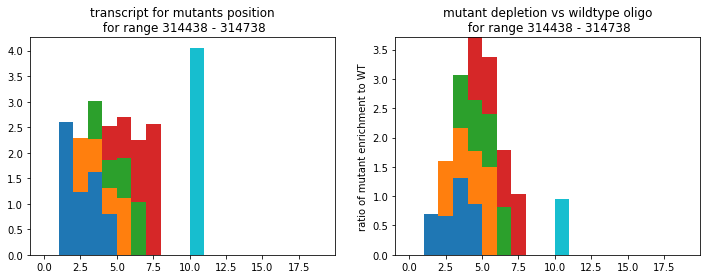

<Figure size 432x288 with 0 Axes>

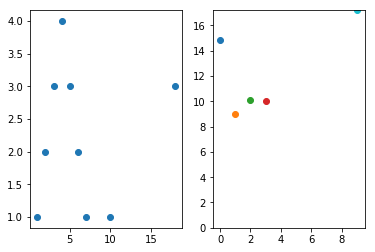

<Figure size 432x288 with 0 Axes>

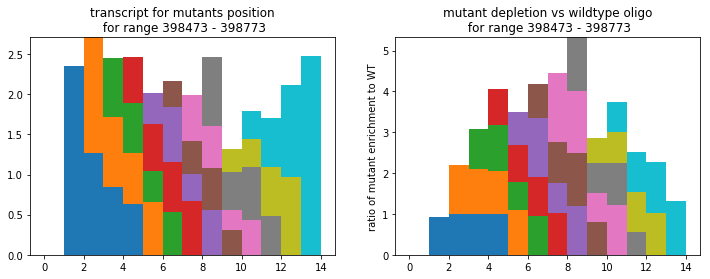

<Figure size 432x288 with 0 Axes>

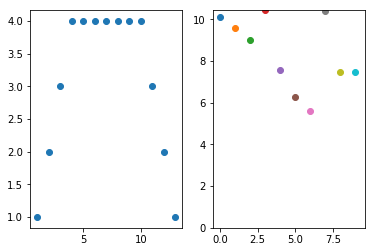

<Figure size 432x288 with 0 Axes>

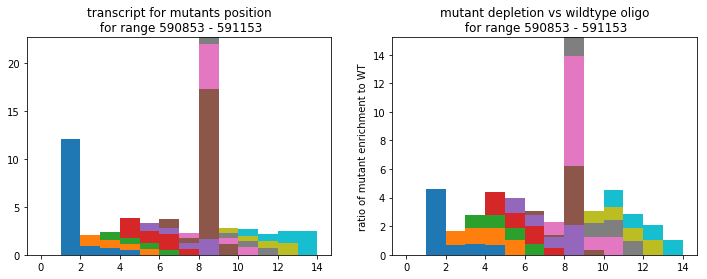

<Figure size 432x288 with 0 Axes>

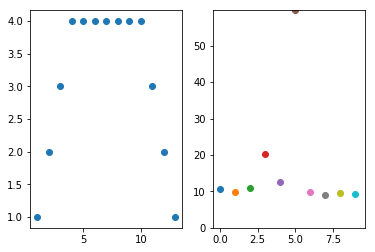

<Figure size 432x288 with 0 Axes>

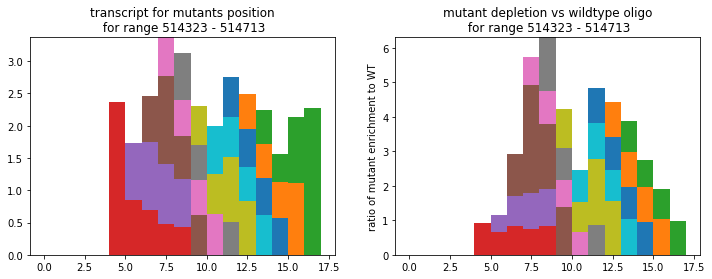

<Figure size 432x288 with 0 Axes>

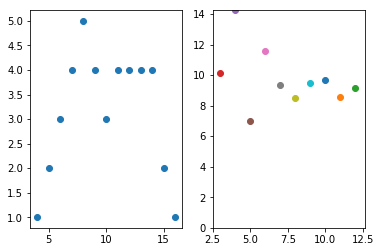

<Figure size 432x288 with 0 Axes>

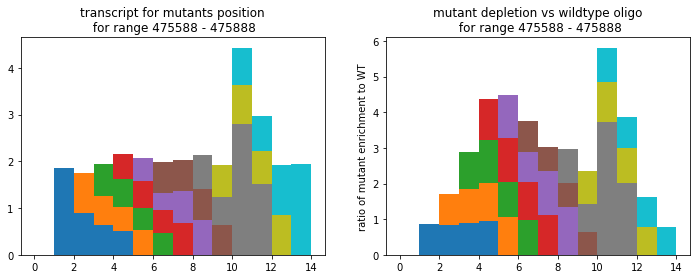

<Figure size 432x288 with 0 Axes>

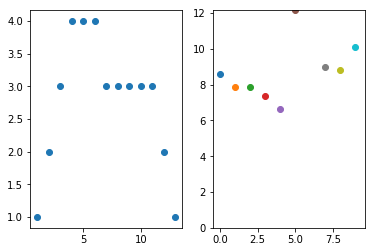

<Figure size 432x288 with 0 Axes>

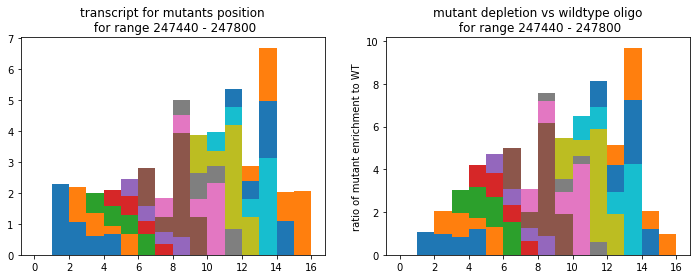

<Figure size 432x288 with 0 Axes>

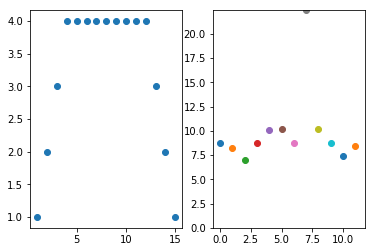

<Figure size 432x288 with 0 Axes>

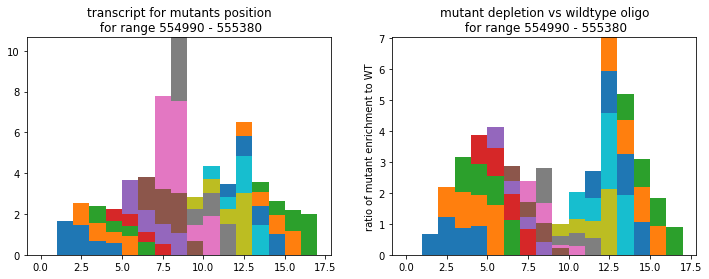

<Figure size 432x288 with 0 Axes>

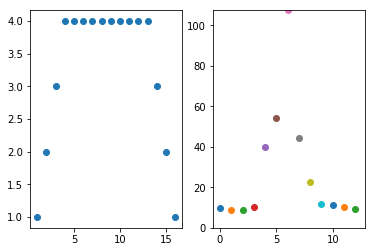

<Figure size 432x288 with 0 Axes>

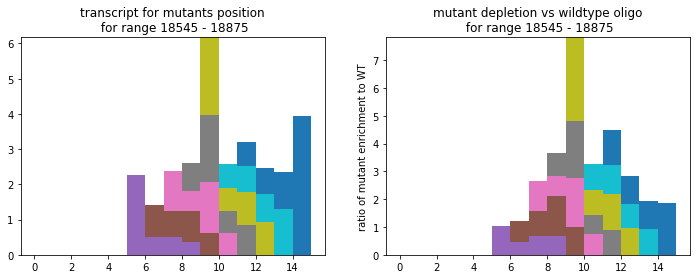

<Figure size 432x288 with 0 Axes>

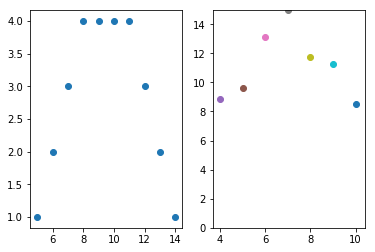

<Figure size 432x288 with 0 Axes>

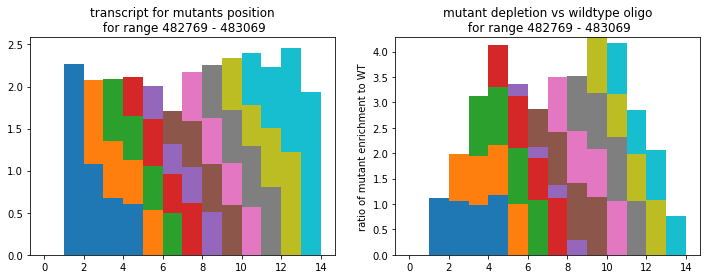

<Figure size 432x288 with 0 Axes>

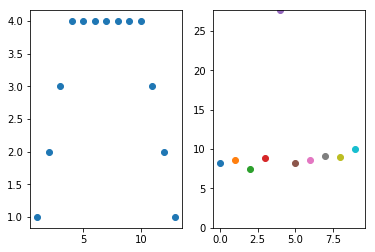

<Figure size 432x288 with 0 Axes>

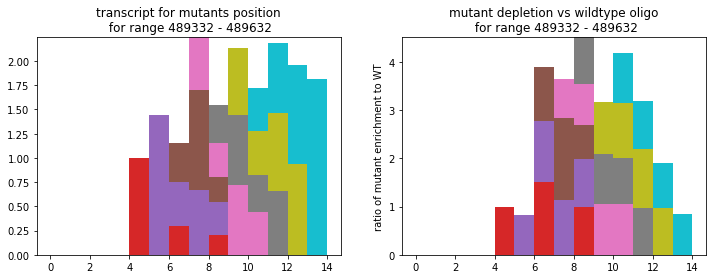

<Figure size 432x288 with 0 Axes>

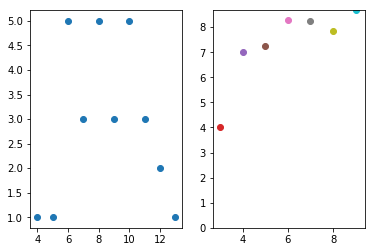

<Figure size 432x288 with 0 Axes>

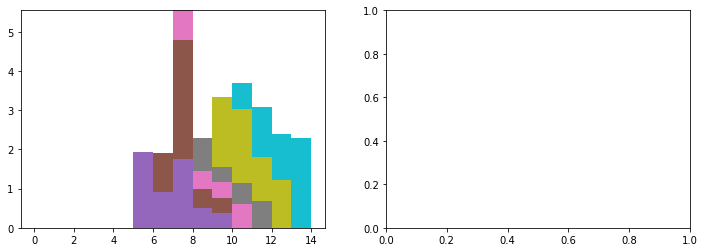

In [34]:
import itertools as it


oifinite = oligo_info2.fillna(0).loc[oligo_info2.exp != "other"]
peakrows = simple_peaks.fillna(0).loc[simple_peaks.exp != "other"]
print len(peakrows.groupby("starts"))

startgroups =[(int( k) / 600,k) for k,rows in peakrows.groupby("starts")]
startgroups_dict = dict([[k, list([r[1] for r in g])] for k, g in it.groupby(sorted(startgroups, key = lambda x: x[0] ),key = lambda x:x[0])])


f1, allsubs = plt.subplots(2,6, sharex=True, sharey=True)
for s in allsubs:
  for s2 in s:
    s2.set_xlim(0,15)
f1.set_size_inches(12,6)
plt.tight_layout()


peak_oligos = pd.DataFrame()
start_delta = 5
cnt = 0
for k,starts in startgroups_dict.items()[:-1]:
    plt.figure()
    
    augmented_starts = list(np.arange(-start_delta,-1)*30 + starts[0]) + starts  + list(np.arange(len(starts),len(starts)+start_delta)*30+starts[0])
    
    yvals= []
    xvals= []
    yvals_norm =[]
    colors = []
    baselines = []
    baseline_is = []
    
    #f, subs = plt.subplots(2,1)
    #f.set_size_inches(12,6)
    for i,s in enumerate(augmented_starts):
        all_df =  oifinite.loc[(oifinite.starts == s)]
        peak_oligos = peak_oligos.append(all_df.copy())
        peak_oligos.loc[all_df.index,"peakid"] = cnt
        
        if len(all_df) == 0: continue
        baseline_df =all_df.loc[(all_df.mutant_num==0)]
        mutated_df = all_df.loc[all_df.mutant_num>0]
        
        baseline_expr = (baseline_df.n_transcripts/ baseline_df.n_observed_bcs).mean()
        mut_counts  = mutated_df.groupby("mutant_num").agg(lambda x: (x.n_transcripts/x.n_observed_bcs ).mean(),)
        for j in range(1,5):
           if not j in mut_counts.index:
               mut_counts = mut_counts.append(pd.Series(0,name=i)).fillna(0)
                
        if len(mut_counts) == 0: continue
        if len(baseline_df) == 0: continue
        if baseline_expr == 0: continue

        baselines += [baseline_expr*4]
        baseline_is +=[i]
        yvals_norm += [list(mut_counts.iloc[:,0] / baseline_expr)]
#        print (baseline_df.n_transcripts/ baseline_df.n_total_bcs).mean(), mut_counts
#        print  yvals_norm
        yvals += [list(mut_counts.iloc[:,0])]
        xvals += [list(mut_counts.index +i)]
        colors += ["C{}".format(i%10)]

        
        #subs[0].plot(mut_counts.index +i, mut_counts )
        #subs[1].scatter(i, (baseline_df.n_transcripts / baseline_df.n_total_bcs).mean(),color = colors[-1])
        
    f,subs = plt.subplots(1,2)
    f.set_size_inches(12,4)
    xvals = np.array(xvals)
    yvals = np.array(yvals)
    totals = dict([(idx, [  e for xv in xvals  for e in xv ].count(idx)) for idx in set(x for xv in xvals for x in xv)]) #[dict([e, list(xv).count(e)] for e in set(xv) ) for xv in xvals]
    #weighted_yvals = [[y / totals[i][xvals[i][j]]  for j,y in enumerate(yv) if totals[i][xvals[i][j]] != 0 ] for i, yv in enumerate( yvals)]
    #totals =[dict([e, list(xv).count(e)] for e in set(xv) ) for xv in xvals]
    weighted_yvals = [[y / totals[xvals[i][j]]  for j,y in enumerate(yv) if totals[xvals[i][j]] != 0 ] for i, yv in enumerate( yvals)]
       
    
        
    subs[0].hist([list(e) for e in xvals], weights =[list(e) for e in weighted_yvals], 
                 bins = range(0, max(max(xs) for xs in xvals)+2),histtype="barstacked", color=colors,
                
                )

    allsubs[cnt/6,cnt%6].hist([list(e) for e in xvals], weights =[list(e) for e in weighted_yvals], 
                 bins = range(0, max(max(xs) for xs in xvals)+2),histtype="barstacked", color=colors,
                
                )
    allsubs[cnt/6,cnt%6].set_title("P{0}: {1}-{2}".format(cnt,augmented_starts[0],augmented_starts[-1]))
    cnt+=1
    subs[1].hist([list(e) for e in xvals], 
                 weights =yvals_norm, bins = range(0, max(max(xs) for xs in xvals)+2),
                 histtype="barstacked", color=colors)
    
    subs[1].set_ylabel("ratio of mutant enrichment to WT")
    subs[0].set_title("transcript for mutants position\n for range {} - {}".format(augmented_starts[0],augmented_starts[-1]))
    subs[1].set_title("mutant depletion vs wildtype oligo\n for range {} - {}".format(augmented_starts[0],augmented_starts[-1]))

                                
    f = plt.figure()
    f,subs = plt.subplots(1,2)
    subs[0].scatter(totals.keys(),totals.values())
    #plt.scatter(totals.keys(),totals.value[s())
    for i, b in enumerate(baselines):
        subs[1].scatter(baseline_is[i],[b], c = "C{}".format((baseline_is[i])%10))
    subs[1].set_ylim(0, max(baselines))
        
        #print baseline_exp

print len(set([k[0] for k in startgroups]))

In [36]:
peak_oligos["mutation_start"] = peak_oligos.starts + (peak_oligos.mutant_num-1)*30
peak_oligos.loc[peak_oligos.mutant_num == 0, "mutation_start"] = None
peak_oligos["enrichment"] = peak_oligos.n_transcripts / peak_oligos.n_observed_bcs



ValueError: x and y must be the same size

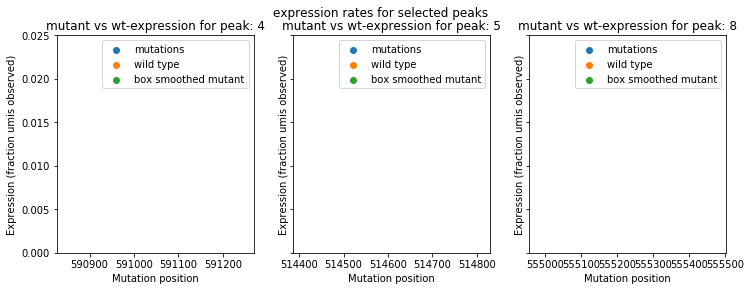

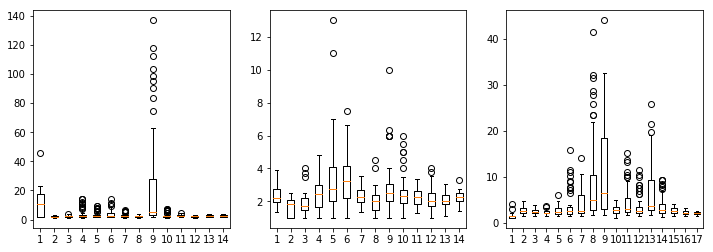

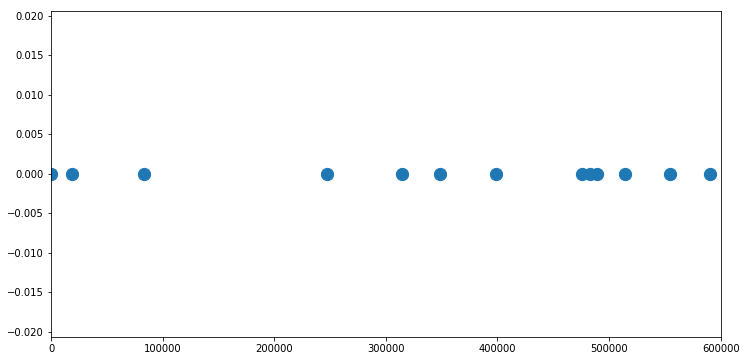

In [38]:

f1,subs1 = plt.subplots(1,3,sharex=False,sharey=True)
f1.set_size_inches(12,4)
f3,subs3 = plt.subplots(1,3,sharex=False,sharey=False)
f3.set_size_inches(12,4)
selections = pd.DataFrame()

cnt = -1
for i in [4,5,8]:
    cnt+=1
    po = peak_oligos.loc[(peak_oligos.peakid == i) & (peak_oligos.n_transcripts >=0)].copy()

    #print po.mutation_start.unique()
    enrichments = po.loc[pd.notnull(po.mutation_start)].groupby("mutation_start").enrichment.median()
    
    wtvals = pd.DataFrame()
    #print po.mutation_start.unique()
    for s in po.loc[pd.notna(po.mutation_start)].mutation_start.unique():
        wtoverlaps = po.loc[(po.mutant_num ==0 ) & (po.starts > s-151 ) & (po.starts < s+1)]
        wtvals.at[s,"wtval"] = wtoverlaps.enrichment.mean()
        
    enrichments = po.loc[pd.notnull(po.mutation_start)].groupby("mutation_start").enrichment.median()
    #enrichments = po.loc[pd.notnull(po.mutation_start)].groupby("mutation_start").enrichment.median()
    
    #po.loc[po.mutation_start.notnull()].groupby(po.mutation_start)
    #po.loc[po.mutation_start.notnull()].groupby(po.mutation_start - 30)
    #po.loc[po.mutation_start.notnull()].groupby(po.apply(lambda x: x.mutation_start - 30,axis = 1))
    enrichments2 = po.loc[po.mutation_start.notnull()].groupby(po.loc[po.mutation_start.notnull()]\
                                            .apply(lambda x: x.mutation_start - 30,axis = 1)).enrichment.median()
   
    
    esmooth = (enrichments+enrichments2) / 2
    selections = selections.append(peak_oligos.loc[peak_oligos.starts.isin(esmooth.loc[esmooth < .005].index)])
    wts = po.loc[po.mutant_num == 0].groupby("peakid").enrichment.agg("median")
    wtstarts = po.loc[po.mutant_num == 0].groupby("peakid").starts.agg("first")

    muts = po.loc[po.mutant_num != 0].groupby("peakid").enrichment.agg("median")
    mutstarts = po.loc[po.mutant_num != 0].groupby("peakid").starts.agg("first")

    
    
    subs1[cnt].set_ylabel("Expression (fraction umis observed)")
    subs1[cnt].set_xlabel("Mutation position")

    subs1[cnt].scatter(enrichments.index, enrichments, label ="mutations")
    subs1[cnt].scatter(wtvals.index, wtvals, label="wild type")
    subs1[cnt].scatter(esmooth.index, esmooth, label="box smoothed mutant")

    subs3[cnt].boxplot([r.enrichment 
                 for k,r in po.loc[pd.notnull(po.mutation_start)]\
                 .groupby("mutation_start")])
    subs1[cnt].scatter( wtstarts, wts,label= None)
    subs1[cnt].scatter( mutstarts, muts, label = None)
    #print max(wtvals.max()+enrichments.max())

    #print max([enrichments.max(),wtvals.max()])
    #subs[0].set_ylim([0,max([enrichments.max(),wtvals.max()])])
    subs1[cnt].set_ylim([-.000,.025])
    subs1[cnt].set_title("mutant vs wt-expression for peak: {}".format(i))
    #subs3[cnt].set_yscale("log")
    subs1[cnt].legend()
    #subs[0].autoscale(enable=True, axis='y', tight=True)

f1.suptitle("expression rates for selected peaks")

f2,subs2 = plt.subplots(1,1)
f2.set_size_inches(12,6)
subs2.set_xlim(0,600000)
subs2.scatter(peak_oligos.groupby("peakid").starts.agg("first"),
              np.zeros(len(peak_oligos.groupby("peakid").starts.agg("first"))),
              150,label="all peaks")
subs2.scatter(selections.groupby("peakid").starts.agg("first"),
              [0]*3,
              selections.groupby("peakid").n_transcripts.sum(),edgecolor="black",color="none")

subs2.set_xlim(0,600000)
subs2.set_ylim(-.15,.15)

subs2.scatter(selections.groupby("peakid").starts.agg("first"),
              [0]*3,150,label="selected peaks")

subs2.legend(loc=4)



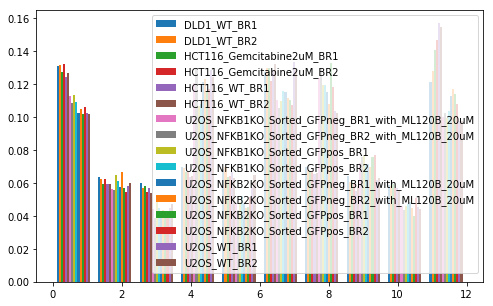

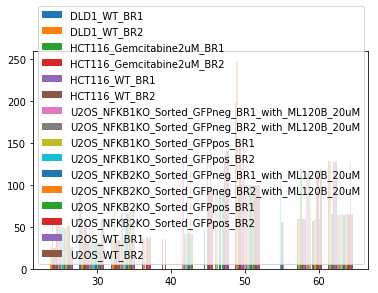

In [40]:
peak_expressions = peak_oligos.groupby(["exp","peakid"]).apply(lambda x:x.enrichment)


plt.hist([ [l + v*0 
             for l in peak_expressions.index.levels[1]  
   for v in peak_expressions.fillna(0).loc[ex,l].values ]
 for ex in  peak_expressions.index.levels[0] 

         ],
         weights =[ [v/len(peak_expressions.fillna(0).loc[ex,l].values)  #normalize the weights by # of oligos
                     for l in peak_expressions.index.levels[1]  
           for v in peak_expressions.fillna(0).loc[ex,l].values ]
         for ex in  peak_expressions.index.levels[0] 
         ]  ,label = peak_expressions.index.levels[0],
         density=True
        )
plt.gcf().set_size_inches(8,5)
plt.legend()

plt.figure()
plt.hist([ [len(peak_expressions.loc[ex,l])  #normalize the weights by # of oligos
                     for l in peak_expressions.index.levels[1]  
           for v in peak_expressions.fillna(0).loc[ex,l].values ]
         for ex in  peak_expressions.index.levels[0] 
         ],label =peak_expressions.index.levels[0] )
plt.legend()
pass




In [41]:
exps = peak_oligos.exp.unique()
peakgroups = peak_oligos.groupby(["exp","peakid"]).enrichment.sum()




#subs2.scatter(peak_oligos.groupby("peakid").starts.agg("first"),
#              np.zeros(len(peak_oligos.groupby("peakid").starts.agg("first"))),
#              150,label="all peaks")

0
Series([], Name: enrichment, dtype: float64)


/cluster/bh0085/anaconda27/lib/python2.7/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


ValueError: Axis limits cannot be NaN or Inf

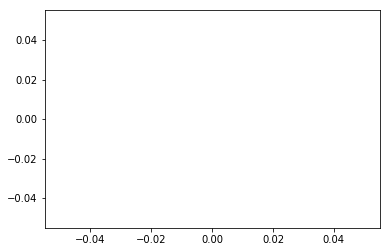

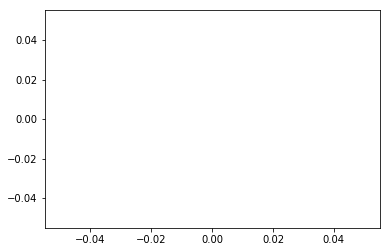

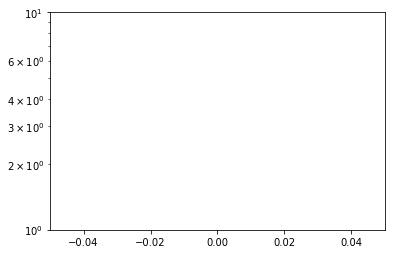

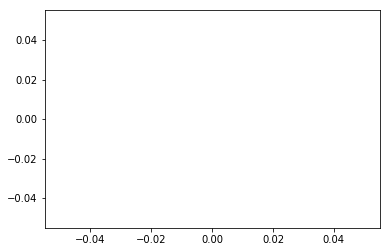

In [42]:
p8 = selections.loc[selections.peakid == 8]

len(selections)
rangesel = peak_oligos.loc[(peak_oligos.starts> p8.starts.min()) & (peak_oligos.starts<= p8.starts.max())]
print len(rangesel)
plt.scatter(rangesel.loc[rangesel.mutant_num==0].starts, 
            rangesel.loc[rangesel.mutant_num ==0].enrichment)

plt.scatter(rangesel.loc[rangesel.mutant_num!=0].starts, 
            rangesel.loc[rangesel.mutant_num !=0].enrichment)
plt.scatter(p8.loc[p8.mutant_num ==0].starts, p8.loc[p8.mutant_num ==0].enrichment)
plt.figure()

plt.hist([selections.loc[selections.mutant_num!=0].enrichment,
          selections.loc[selections.mutant_num==0].enrichment],density = True,bins = np.linspace(0,.25,25))
#plt.hist(selections.loc[selections.mutant_num!=0].enrichment,density = True,bins = np.linspace(0,.15,25))
#plt.gca().set_yscale("log")


plt.figure()
plt.autoscale(enable=True, tight=True)

plt.gca().set_yscale("log")
plt.scatter(p8.starts, p8.enrichment+.001,color = p8.mutant_num.apply(lambda x:"red" if x == 0 else "blue"))


plt.figure()
mgroup2 = (p8.loc[p8.mutant_num!=0]).groupby("mutation_start").enrichment.agg('median')
mgroup = (p8.loc[p8.mutant_num==0]).groupby("starts").enrichment.agg('median')

print mgroup
plt.scatter(mgroup.index, mgroup, 200)
plt.scatter(mgroup2.index, mgroup2)

plt.gca().set_ylim(0, mgroup.max()+mgroup2.max()) #rangesel.enrichment.max())



In [ ]:
peakofinterest = 4,5,8,10

In [ ]:
oligo_info2.mutant_num.unique()

In [ ]:
["C{}".format(i) for i in range(len(baselines))]

In [ ]:
xvals

In [ ]:
totals

In [ ]:
    weighted_yvals = [[y / totals[xvals[i][j]]  for j,y in enumerate(yv) if totals[[i][j]] != 0 ] for i, yv in enumerate( yvals)]


In [ ]:
#[[yv for j,y in enumerate(yv) if totals[xvals[i][j]] != 0 ] for i, yv in enumerate( yvals)]
#[yv for i,yv in enumerate( yvals)]
xvals[0]

In [ ]:
totals

In [ ]:
y

In [ ]:
xvals

In [ ]:
dict([(idx, [  e for xv in xvals  for e in xv ].count(idx)) for idx in set(x for xv in xvals for x in xv)])

In [ ]:
[e for e1 in totals for e in e1.values()]

In [ ]:
[e for e1 in totals for e in e1.values()]

In [ ]:
mut_counts.index.levels[0]

In [ ]:
startgroups_dict

In [ ]:
baseline_df

In [ ]:
list([v for k,v in startgroups_dict.iteritems()])

In [ ]:
#oligo_info2.starts.isin([e for k,v in startgroups_dict.iteritems() for e in v]).sum()

In [ ]:
#plt.hist(oifinite.loc[oifinite.starts.isin([e for k,v in startgroups_dict.iteritems() for e in v])].n_observed_bcs ,density =True )
#plt.hist(oifinite.n_observed_bcs, density = True)

peak_oligos = oifinite.loc[oifinite.starts.isin([e for k,v in startgroups_dict.iteritems() for e in v])]
print "selected peaks mean {}".format(oifinite.loc\
                                      [oifinite.starts.isin([e for k,v in startgroups_dict.iteritems() for e in v])]\
                                      .apply(lambda x:x.n_transcripts / x.n_total_bcs,axis = 1).mean())
print "all means {}".format((oifinite.n_transcripts/ oifinite.n_total_bcs).mean())



In [ ]:
 all_df.groupby("mutant_num").apply(lambda x: x.n_transcripts)

In [ ]:
all_df.groupby("mutant_num").agg(lambda x:x.n_transcripts.sum())

In [ ]:
np.arange(-4,-1)*30 + starts[0]

In [ ]:
np.arange(len(starts),len(starts+3))*30+starts[0]

In [ ]:
mut_counts.index

In [ ]:
mut_counts

In [ ]:
all_df

In [ ]:
mut_counts

In [ ]:
mut_counts

In [ ]:
mut_counts

In [ ]:
mut_counts

In [ ]:
len(xvals)

In [ ]:
len(startgroups_dict)

In [ ]:
import itertools as it

peakrows = simple_peaks.dropna()
print len(peakrows.groupby("starts"))

startgroups =[(int( k) / 600,k) for k,rows in peakrows.groupby("starts")]
startgroups_dict = dict([[k, list([r[1] for r in g])] for k, g in it.groupby(sorted(startgroups, key = lambda x: x[0] ),key = lambda x:x[0])])

for k,starts in startgroups_dict.items()[:-1]:
    plt.figure()
    
    augmented_starts = list(np.arange(-3,-1)*30 + starts[0]) + starts  + list(np.arange(len(starts),len(starts)+3)*30+starts[0])
    
    yvals= []
    xvals= []
    for i,s in enumerate(augmented_starts):
        all_df =  oifinite.loc[(oifinite.starts == s)]
        if len(all_df) == 0: continue
        baseline_df =all_df.loc[(all_df.mutant_num==0)]
        mut_counts  = all_df.groupby("mutant_num").agg(lambda x: (x.n_transcripts / x.n_total_bcs).mean(),)
        yvals += list(mut_counts.iloc[:,0])
        xvals += list(mut_counts.index +i)

        plt.plot(mut_counts.index +i, mut_counts )
        
    plt.figure()
    xvals = np.array(xvals)
    yvals = np.array(yvals)
    totals =dict([e, list(xvals).count(e)] for e in set(xvals) )
    weighted_yvals = [y / totals[xvals[i]]  for i,y in enumerate(yvals) if totals[xvals[i]] != 0 ]
    plt.hist(xvals, weights =weighted_yvals, bins = range(min(xvals)-3, max(xvals)+3))
    

                                
        
        
        #print baseline_exp

print len(set([k[0] for k in startgroups]))

In [ ]:
[[k, [list([r[1] for r in g])]] for k, g in it.groupby(sorted(startgroups, key = lambda x: x[0] ),key = lambda x:x[0])]

In [ ]:
startgroups_dict

In [ ]:
cols

In [ ]:
cols = enrichments.columns
drugs =[ "HCT116_Gemcitabine2uM_BR1", "HCT116_Gemcitabine2uM_BR2"]
nodrugs = ["HCT116_WT_BR1","HCT116_WT_BR1"]
#for i, loc in enumerate(simple_peaks.locus_ids.unique):
plt.scatter(simple_peaks.starts,np.log(
    ematrix.loc[simple_peaks.id][drugs].mean(axis=1) /\
    ematrix.loc[simple_peaks.id][nodrugs].mean(axis=1)),color=["C{}".format(int(1) if e ==0 else 0) for e in simple_peaks.mutant_num])


celllines = {"U2OS":["U2OS_WT_BR1","U2OS_WT_BR2"],
             "DLD1":["DLD1_WT_BR1","DLD1_WT_BR2"],
            "HCT116":["HCT116_WT_BR1","HCT116_WT_BR2"]}

plt.figure()
plt.scatter(simple_peaks.starts,np.log(ematrix.loc[simple_peaks.id][celllines["DLD1"]].mean(axis=1) /\
                                       ematrix.loc[simple_peaks.id][celllines["U2OS"]].mean(axis=1))
           ,color=["C{}".format(int(1) if e ==0 else 0) for e in simple_peaks.mutant_num])

plt.figure()
plt.scatter(simple_peaks.starts,np.log(ematrix.loc[simple_peaks.id][celllines["HCT116"]].mean(axis=1) /\
                                       ematrix.loc[simple_peaks.id][celllines["DLD1"]].mean(axis=1))
           ,color=["C{}".format(int(1) if e ==0 else 0) for e in simple_peaks.mutant_num])

plt.figure()
plt.scatter(simple_peaks.starts,np.log(ematrix.loc[simple_peaks.id][celllines["HCT116"]].mean(axis=1) /\
                                       ematrix.loc[simple_peaks.id][celllines["U2OS"]].mean(axis=1))
           ,color=["C{}".format(int(1) if e ==0 else 0) for e in simple_peaks.mutant_num])

f = plt.figure()
plt.scatter(simple_peaks.starts,\
            [ematrix.loc[simple_peaks.loc[simple_peaks.locus_ids==locid].id].max().max() for locid in simple_peaks.locus_ids])

f.set_size_inches(12,6)

In [ ]:

enrichments = pd.DataFrame()
enrichments_vs_all = pd.DataFrame()
observations_vs_all = pd.DataFrame()
#enrichments.index =pd.Series( oligo_info2.oligo.unique())
for k,g in oligo_info2.groupby("exp"):
    #print  g.apply(lambda x:x.n_transcripts / x.n_observed_bcs)
    enrichments[k] = pd.Series(g.apply(lambda x:x.n_transcripts / x.n_observed_bcs if x.n_observed_bcs > 0 else 0, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    enrichments_vs_all[k] = pd.Series(g.apply(lambda x:x.n_transcripts / x.n_total_bcs if x.n_total_bcs > 0 else 0, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    observations_vs_all[k] = pd.Series(g.apply(lambda x:x.n_observed_bcs / x.n_total_bcs if x.n_total_bcs > 0 else 0, axis = 1).values,index = g.apply(lambda x:x.id,axis=1))
    #enrichments[k+"_vs_bcs"] = g.apply(lambda x:x.n_transcripts / x.n_observed_bcs, axis = 1)
enrichments = enrichments.drop(columns=["other"])
enrichments_vs_all = enrichments_vs_all.drop(columns=["other"])

#plt.gca().("log")

In [ ]:
print len(enrichments)
print len(oligo_info2.id.unique())

In [ ]:
enrichments.sort_values("HCT116_Gemcitabine2uM_BR1",ascending = False)

In [ ]:
np.percentile((oligo_info2.n_transcripts / oligo_info2.n_observed_bcs),99.9)

len(oligo_info2)*.001
topset = oligo_info2.iloc[np.nonzero((oligo_info2.n_transcripts / oligo_info2.n_observed_bcs )> 8)[0]]
plt.scatter(topset.starts,topset.n_transcripts / topset.n_observed_bcs)

In [ ]:
plt.hist(oligo_info2.n_transcripts / oligo_info2.n_total_bcs, bins = np.logspace(np.log10(0.0001),np.log10(50), 50))

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")

plt.figure()
plt.hist(oligo_info2.n_transcripts / oligo_info2.n_observed_bcs, bins = np.logspace(np.log10(.5),np.log10(50), 50))

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")


In [ ]:
plt.plot(sorted(oligos_lib.starts))
#oligos_lib.starts
oligos_lib.chromosome_info

In [ ]:
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt


In [ ]:
oligos_lib = OLIGO_LIBRARY
oligos_lib["id"] = oligos_lib.index
oligo_info2 = oligo_info.copy().join(oligos_lib, on ="oligo").dropna()

In [ ]:
positive_controls = pd.read_csv(POSITIVE_CONTROLS_FILE)
positive_control_rows = oligo_info2.loc[oligo_info2.RefSeqID.isin(positive_controls.Name)]

Q: Given the list of positive control oligos which are known to be expressed, do we see these in the transcript data? Are they transcribed abundantly?

In [ ]:

f, subs = plt.subplots(1,1)

s = subs
s.semilogy()
positive_control_info = oligo_info.loc[oligo_info.oligo.isin(positive_control_rows.id)]
bins = np.linspace(0,150,75)
s.hist(oligo_info2.n_transcripts, density=True, bins = bins, label="all oligos")
s.hist(positive_control_rows.n_transcripts, density=True, bins = bins, label="positive controls")
s.set_title("total transcript abundance distribution")
s.set_xlabel("transcript count")
s.set_ylabel("p(x)")
s.legend()



pass

In [ ]:
oi2_finite = oligo_info2.dropna()
transcript_groups = oi2.groupby("mutant_num").n_transcripts

h = plt.hist([e[1].values for e in transcript_groups], bins = np.linspace(0,20,10),density=True,label = ["Mutation at position {}".format(k) if k != 0 else "No mutation" for k,v in transcript_groups])
plt.legend()


plt.gca().set_ylabel("frequency")
plt.gca().set_xlabel("# of transcripts observed / oligo")

#plt.hist([list(v for v in grp) for grp in transcript_groups], bins = np.linspace(0,20), density = True)
#plt.legend()

plt.title("histogram of transcript count,\n broken down by mutation position")

In [ ]:
transcript_groups.agg("mean")

#TABLE 1#
Enrichment counts for each oligo in each cell conditioned, in a table

In [ ]:
import scipy.stats as stats

f,subs = plt.subplots(3,1)
f.set_size_inches(8,12)

label = enrichments.columns

subs[0].hist([enrichments.values.transpose()[i,np.nonzero(col>0)[0]] for i,col in  enumerate(enrichments.values.transpose())]
             ,bins = np.linspace(0,4,100),
             density = True,histtype ="step",
            label = label)
subs[1].hist([enrichments_vs_all.values.transpose()[i,np.nonzero(col>0)[0]] for i,col in  enumerate(enrichments_vs_all.values.transpose())],
             bins = np.linspace(0,.025,100),density = True,histtype ="step", label = label)
subs[2].hist([observations_vs_all.values.transpose()[i,np.nonzero(col>0)[0]] for i,col in  enumerate(observations_vs_all.values.transpose())],
             bins = np.linspace(0,.025,100),density=True,histtype ="step", label = label)

subs[0].set_title("number of transcripts / number of umi barcodes observed in transcript sequencing \nby experimental condition")
subs[1].set_title("number of transcripts / number of umi barcodes observed in oligo library sequencing \nby experimental condition")
subs[2].set_title("fraction of transcipt umis matched to\n barcodes in oligo sequencing")

for s in subs:
    s.legend()
    s.set_xlabel("enrichment")
plt.tight_layout()

In [ ]:
plt.hist(stats.zscore(enrichments_vs_all.values.transpose()[0]))

In [ ]:
bins = np.linspace(0,600000,200)
z_2 =enrichments.loc[stats.zscore(col[np.nonzero(col>0)[0]])>4]
plt.hist(oligo_info2.loc[oligo_info2.oligo.isin(z_2.index)].starts,bins =bins)
pass

In [ ]:

plt.hist([stats.zscore(col[np.nonzero(col>0)[0]]) for i,col in  enumerate(enrichments_vs_all.values.transpose())],   
         bins = np.linspace(-2,3,100),
         density = True,histtype ="step", label = label)
plt.legend()
pass

In [ ]:

f, subs = plt.subplots(3,1)
f.set_size_inches(8,12)
s = subs[0]
for i in range(len(enrichments.columns)):
    s.scatter(enrichments.iloc[:,i].transpose(),enrichments_vs_all.iloc[:,i].transpose())
    
    
s.legend()
s.set_title("enrichment of transcripts in observed bcs vs in all")
s.set_ylabel("vs all barcodes")
s.set_xlabel("vs observed bcs only")

s = subs[1]
for i in range(len(enrichments.columns)):
    s.scatter(enrichments_vs_all.iloc[:,i].transpose(),observations_vs_all.iloc[:,i].transpose())
    
    
s.legend()
s.set_title("txn counts against all vs umi fraction bc observed")
s.set_ylabel("umiobs vs all")
s.set_xlabel("txnum vs all")


s = subs[2]
for i in range(len(enrichments.columns)):
    s.scatter(enrichments.iloc[:,i].transpose(),observations_vs_all.iloc[:,i].transpose())
    
    
s.legend()
s.set_title("txn counts against all vs umi fraction bc observed")
s.set_ylabel("umiobs vs all")
s.set_xlabel("txnum vs all")

s.set_xlim([0,5])
s.set_ylim([0,.04])


plt.tight_layout()


# QUESTION 2: #
what is the genomic distribution of transcript counts?

In [ ]:
expression

In [ ]:
m0series

In [ ]:
m0series

In [ ]:
eva = enrichments_vs_all

In [ ]:

i=5
plt.gcf().set_size_inches(12,4)
m0 = enrichments_vs_all.loc[oligos_lib.mutant_num == 0]
for i in range(8):
    m0series = pd.Series(eva.iloc[:,i].values, index = eva.apply(lambda x: oligos_lib.loc[x.name].starts,axis=1).values, )
    plt.scatter(m0series.index,m0series, 50,label = eva.columns[i])
    
plt.legend()
plt.legend()

In [ ]:

f,subs = plt.subplots(9,1)
f.set_size_inches(16,32)

enrichments_vs_all["starts"] = oligos_lib.starts
#enrichments_vs_all["starts"] = oligos_lib.starts

s1 = subs[0]
s2 = subs[1]
s3 = subs[2]

etype = enrichments

#enrichments = enrichments.join(oi2,other=oligos_lib,on="id")
for i in range(8):
    print i
    filter_loc =enrichments.mutant_num == 0
    s1.scatter(flt.loc[filter_loc].starts,enrichments_vs_all.loc[filter_loc].iloc[:,i])

    
m0 = etype.loc[oligos_lib.mutant_num == 0]
for k in range(1,6):
    m1 = etype.loc[oligos_lib.mutant_num == k]
    print(k)
    #enr = enrichments_vs_all.iloc[:,]
    for i in range(8):
        print i

        mseries = pd.Series(m1.iloc[:,i].values, index = m1.apply(lambda x: oligos_lib.loc[x.name].starts,axis=1).values)
        m0series = pd.Series(m0.iloc[:,i].values, index = m0.apply(lambda x: oligos_lib.loc[x.name].starts,axis=1).values)
        
        subs[i+1].plot((m0series / mseries).index,np.log(m0series / mseries),"o")
        subs[i+1].set_xlim(275000,300000)
s1.set_title("unmutated expression levels")
s2.set_title("WT vs mutant expression ")



In [ ]:
plt.scatter(m1.starts.values,m1.iloc[:,0])

In [ ]:
enrichments_vs_all.iloc[:,:-1]

In [ ]:
oligo_info2.to_csv("../data/0301_oligo_summary_stats.csv")
enrichments_vs_all.iloc[:,:-1].to_csv("../data/0301_enrichment_data.csv")

In [ ]:
ba

In [ ]:
m0vals = enrichments_vs_all.loc[set(oi2.loc[oi2.mutant_num==0].oligo)]

#plt.plot(m0vals.starts,m0vals.iloc[:,:8].apply(lambda x:x.iloc[:8].mean(),axis=1),"o")
m0vals.fillna(0)
m0vals = m0vals.sort_values("starts")

plt.plot(m0vals.starts,m0vals.iloc[:,:8].apply(lambda x:x.iloc[:8].mean(),axis=1))

In [ ]:
from scipy import signal
import scipy
import scipy.signal

f,subs = plt.subplots(1,1)
f.set_size_inches(12,6)
#scipy.signal.find_peaks(m0sig.signal)


m0vals = enrichments_vs_all.loc[set(oi2.loc[oi2.mutant_num==0].oligo)]
m0vals.fillna(0)
m0vals = m0vals.sort_values("starts")
plt.plot(m0vals.starts,m0vals.iloc[:,:2].apply(lambda x:x.iloc[:8].mean(),axis=1))
m0sig = pd.concat([pd.Series(oligos_lib.loc[oligos_lib.mutant_num==0].join(m0vals.iloc[:,:8]).iloc[:,-8:].mean(axis=1),name="signal"),
                             oligos_lib.starts.loc[oligos_lib.mutant_num==0]],axis=1)
m0sig = m0sig.fillna(0)

m0sig = m0sig.sort_values("starts")
#newstarts = np.arange(m0sig.starts.min(),m0sig.starts.max(),30)
m0sig = m0sig.set_index(m0sig.starts).signal

data = m0sig

peakwidth =10
cwdata = scipy.signal.cwt(data, signal.ricker, np.arange(peakwidth,peakwidth+1))[0]

#cwpeaks = scipy.signal.find_peaks_cwt(data,[50,50],signal.ricker)
#plt.plot(scipy.signal.cwt(data, signal.ricker, np.arange(10,50)).transpose())
#plt.scatter(cwpeaks, cwpeaks*0+.05)

peaks,_ = scipy.signal.find_peaks(cwdata)
results_half = signal.peak_widths(cwdata, peaks, rel_height=0.5)
results_full = signal.peak_widths(cwdata, peaks, rel_height=1)

plt.plot(m0sig.index,cwdata)
plt.plot(m0sig.index,data)
plt.plot(m0sig.index[peaks], cwdata[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
#plt.scatter(m0sig.starts/30, m0sig.signal)



In [ ]:
plt.gcf().set_size_inches(12,4)
plt.plot(m0sig.index,cwdata)
plt.plot(m0sig.index,data)
plt.plot(m0sig.index[peaks], cwdata[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.gca().set_xlim(250000,275000)

In [ ]:
a = h1[0]
hr[:100]

In [ ]:
plt.gcf().set_size_inches(12,4)
#plt.hist(m0sig.index,np.linspace(0,600000,600000/30/1),weights=m0sig,density=True,histtype="step")
#plt.hist(m0sig.index,np.linspace(0,600000,600000/30/1),density=True,histtype="step")

h1 = np.histogram(m0sig.index,np.linspace(0,600000,600000/30/2+1),weights=m0sig,density=True)
h2 = np.histogram(m0sig.index,np.linspace(0,600000,600000/30/2+1),density=True)

hr = h1[0]/h2[0]
hr[np.isnan(hr)] = np.percentile(hr[np.isfinite(hr)],10)
#hr[np.isnan(hr)] = 0
plt.plot(h1[1][:-1],hr)

plt.gca().set_xlim(250000,275000)
pass

In [ ]:
newdata = pd.Series(hr,name="signal",index = h1[1][:-1])
data = newdata
peakwidth =5
cwdata = scipy.signal.cwt(data, signal.ricker, np.arange(peakwidth,peakwidth+1))[0]


#cwpeaks = scipy.signal.find_peaks_cwt(data,[50,50],signal.ricker)
#plt.plot(scipy.signal.cwt(data, signal.ricker, np.arange(10,50)).transpose())
#plt.scatter(cwpeaks, cwpeaks*0+.05)

peaks,_ = scipy.signal.find_peaks(cwdata,prominence=.25)
results_half = signal.peak_widths(cwdata, peaks, rel_height=0.5)
results_full = signal.peak_widths(cwdata, peaks, rel_height=1)


f,subs = plt.subplots(1,1)
f.set_size_inches(12,6)

plt.plot(data.index,cwdata)
plt.plot(data.index,data)
plt.plot(data.index[peaks], cwdata[peaks], "x")
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")

plt.gca().set_xlim(250000,275000)

In [ ]:
cwdata

In [ ]:
m0sig

In [ ]:
plt.plot(m0sig.starts)

In [ ]:
#m0vals.groupby("starts").mean()
#m0vals

In [ ]:
plt.plot(m0vals.groupby("starts").mean())

In [ ]:
plt.plot(mseries.starts,mseries, "o")

In [ ]:
oligos_lib.starts

In [ ]:
oi2.groupby("locus_ids")

m1 = enrichments_vs_all.loc[oligos_lib.mutant_num == 1].iloc[:,0]
m0 = enrichments_vs_all.loc[oligos_lib.mutant_num == 0].iloc[:,0]

mseries = pd.Series(m1.values, index = m1.apply(lambda x: oligos_lib.loc[x.name].locus_ids).values)
m0series = pd.Series(m0.values, index = m0.apply(lambda x: oligos_lib.loc[x.name].locus_ids).values)

#enrichments_vs_all.loc[oligos_lib.mutant_num == 1].iloc[:,1]
#m1.apply(lambda x: oligos_lib.loc[x.name].locus_ids,axis=1)


In [ ]:
mseries - m0series

In [ ]:
len(enrichments.loc[enrichments.mutant_num == k].iloc[:,i])

In [ ]:
len(enrichments_vs_all.loc[enrichments.mutant_num == k].iloc[:,i] \
                - enrichments_vs_all.loc[enrichments.mutant_num == 0].iloc[:,i])

In [ ]:
len(enrichments_vs_all.loc[enrichments.mutant_num == 0])